In [1]:
%env ASTERIA=/home/jakob/software/ASTERIA/ASTERIA

from asteria.simulation import Simulation
from analysis import *

import matplotlib.pyplot as plt

env: ASTERIA=/home/jakob/software/ASTERIA/ASTERIA


In [2]:
include_wls = False

trials = 5000
distance = 5*u.kpc
frequency = 400*u.Hz # 50 Hz and 400 Hz, in steps of 50 Hz
amplitude = 0.2 # 1% and 50% in log steps (1%, 2%, 5%, 10%, 20%, 50%)
time_start = 200*u.ms
time_end = 300*u.ms
position="center"

time_res = 1 * u.ms
time_win = [0, 100] * u.s # time independent
freq_res = 1 * u.Hz 
freq_win = [1, 1E6] * u.Hz # freq independent

hann_len = 50*u.ms # length of Hann window
hann_res = 5*u.Hz # relates to frequency resolution from hanning, mfft = freq_sam/freq_sam
hann_hop = 10*u.ms # offset by which Hann window is slided over signal
freq_sam = (1/time_res).to(u.Hz) # = 1/time_res

temp_para = {"frequency": frequency, 
             "amplitude": amplitude, #in percent of max value
             "time_start": time_start,
             "time_end": time_end,
             "position": position}

fft_para = {"time_res": time_res, 
             "time_win": time_win,
             "freq_res": time_start,
             "freq_win": freq_win}

stf_para = {"hann_len": hann_len,
             "hann_res": hann_res,
             "hann_hop": hann_hop, 
             "freq_sam": freq_sam}


model = {'name': 'Sukhbold_2015',
         'param':{
             'progenitor_mass': 9.6*u.Msun, 
             'eos': 'LS220'}
        }

sim = Simulation(model=model,
                 distance=20* u.kpc, 
                 Emin=0*u.MeV, Emax=100*u.MeV, dE=1*u.MeV,
                 tmin=0.000*u.s, tmax=1.000*u.s, dt=time_res,
                 hierarchy = 'normal',
                 mixing_scheme = 'NoTransformation',
                 geomscope = 'Gen2',
                 include_wls = include_wls)
sim.run()



In [3]:
ana = Analysis(sim, dt = time_res, distance=distance, trials = trials, temp_para=temp_para)

# for unknown reasons my data is binned in 2 ms bins instead of 1 ms bins
# for even more unknown reasons this effect is removed when setting the distance anew

ana.set_distance(30*u.kpc)


In [4]:
ana.run(fft_para, stf_para, mode = "STF")

[1.63529267 0.99908775 2.29054108] [5.42846494 4.38871702 6.55114366]


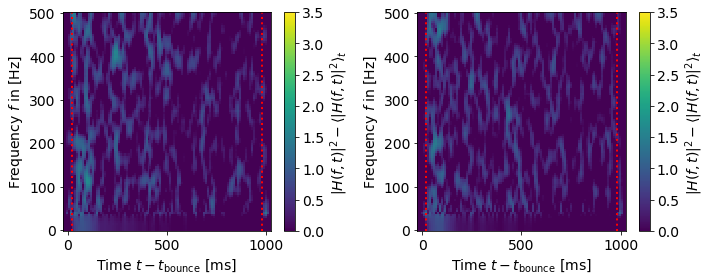

In [5]:
fig, ax = plt.subplots(1,2, figsize = (10,4))

hypos = ["signal", "null"]
im, cb = [None,None], [None,None]

for i in range(2):
    im[i] = ax[i].pcolor(ana.stf_time_edge, ana.stf_freq_edge, ana._log[hypos[i]]["ic86"][0], cmap='viridis', vmin = 0, vmax = 3.5)
    ax[i].axvline(20, color = "r", ls = ":", lw = 2)
    ax[i].axvline(980, color = "r", ls = ":", lw = 2)

    cb = fig.colorbar(im[i])
    cb.ax.tick_params(labelsize=14)
    cb.set_label(label=r"$|H(f,t)|^2 - \langle |H(f,t)|^2 \rangle_t$",size=14)
    ax[i].set_xlabel(r'Time $t-t_{\rm bounce}$ [ms]', fontsize=14)
    ax[i].set_ylabel(f"Frequency $f$ in [Hz]", fontsize=14)
    ax[i].yaxis.get_offset_text().set_fontsize(14)
    ax[i].tick_params(labelsize=14)

plt.tight_layout()

In [6]:
ana._log["signal"]["ic86"].shape, ana.stf_freq_mid.shape, ana.stf_time_mid.shape

((1000, 101, 105), (101,), (105,))

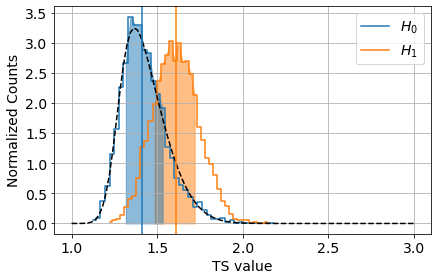

In [10]:
# Plot TS distribution for null and signal hypothesis for IC86

bins = 40

# histogram TS distribution of null and signal hypothesis for IC86 
y_signal, bins_signal = np.histogram(ana.stf_ts["signal"]["ic86"], bins = bins, density = True)
y_null, bins_null = np.histogram(ana.stf_ts["null"]["ic86"], bins = bins, density = True)

# get x values
x_signal = (bins_signal[:-1]+bins_signal[1:])/2
x_null = (bins_null[:-1]+bins_null[1:])/2

# get fitted background distribution
x_fit = np.linspace(1, 3, 100)
y_fit = ana._ts_bkg_fit_ic86.pdf(x_fit)

# mask range of 16% and 84% quantiles
mask_signal = np.logical_and(x_signal > ana.ts_stat["signal"]["ic86"][1], x_signal < ana.ts_stat["signal"]["ic86"][2])
mask_null = np.logical_and(x_null > ana.ts_stat["null"]["ic86"][1], x_null < ana.ts_stat["null"]["ic86"][2])

fig, ax = plt.subplots(1,1)

ax.step(x_null, y_null, where = "mid", label = r"$H_0$")
ax.step(x_signal, y_signal, where = "mid", label = r"$H_1$")
ax.plot(x_fit, y_fit, "k--")

ax.axvline(ana.ts_stat["signal"]["ic86"][0], ymin = 0, ymax =np.max(y_signal), color = 'C1', ls = '-')
ax.axvline(ana.ts_stat["null"]["ic86"][0], ymin = 0, ymax =np.max(y_null), color = 'C0', ls = '-')
ax.fill_between(x = x_signal[mask_signal], y1 = y_signal[mask_signal], color = 'C1', alpha = 0.5)
ax.fill_between(x = x_null[mask_null], y1 = y_null[mask_null], color = 'C0', alpha = 0.5)


ax.set_xlabel("TS value", fontsize = 14)
ax.set_ylabel("Normalized Counts", fontsize = 14)
ax.tick_params(labelsize = 14)
ax.grid()
ax.legend(fontsize = 14)

plt.tight_layout()

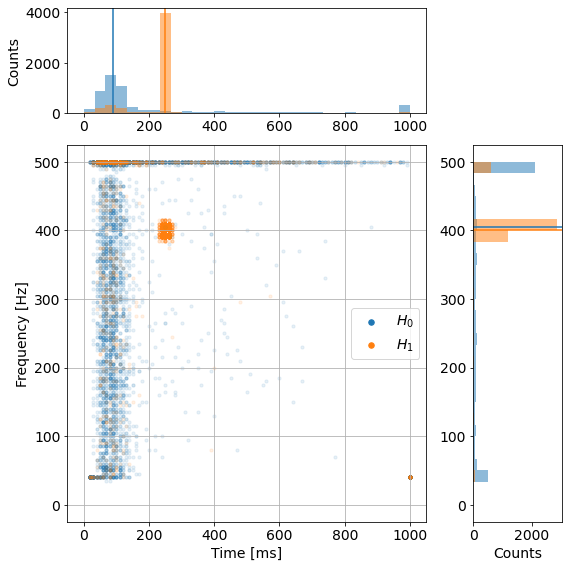

In [8]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Data
fit_freq_null, fit_time_null = ana.stf_fit_freq["null"]["ic86"], ana.stf_fit_time["null"]["ic86"]
fit_freq_signal, fit_time_signal = ana.stf_fit_freq["signal"]["ic86"], ana.stf_fit_time["signal"]["ic86"]

fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(4, 4)

# Main scatter plot
ax_main = fig.add_subplot(gs[1:, :-1])
ax_main.scatter(fit_time_null, fit_freq_null, s=10, alpha=0.1, color="C0", label=r"$H_0$")
ax_main.scatter(fit_time_signal, fit_freq_signal, s=10, alpha=0.1, color="C1", label=r"$H_1$")
ax_main.set_xlabel("Time [ms]", fontsize=14)
ax_main.set_ylabel("Frequency [Hz]", fontsize=14)
ax_main.tick_params(labelsize=14)
ax_main.grid()

# Top histogram
ax_top = fig.add_subplot(gs[0, :-1], sharex=ax_main)
ax_top.hist(fit_time_null, bins=30, range = (0, 1000), alpha=0.5, color="C0", orientation='vertical')
ax_top.hist(fit_time_signal, bins=30, range = (0, 1000), alpha=0.5, color="C1", orientation='vertical')
ax_top.axvline(np.median(fit_time_null), color="C0")
ax_top.axvline(np.median(fit_time_signal), color="C1")

ax_top.set_ylabel("Counts", fontsize=14)
ax_top.tick_params(labelsize=14)

# Right histogram
ax_right = fig.add_subplot(gs[1:, -1], sharey=ax_main)
ax_right.hist(fit_freq_null, bins=30, range = (0, 500), alpha=0.5, color="C0", orientation='horizontal')
ax_right.hist(fit_freq_signal, bins=30, range = (0, 500), alpha=0.5, color="C1", orientation='horizontal')
ax_right.axhline(np.median(fit_freq_null), color="C0")
ax_right.axhline(np.median(fit_freq_signal), color="C1")
ax_right.set_xlabel("Counts", fontsize=14)
ax_right.tick_params(labelsize=14)

# Adjusting legend handles
leg = ax_main.legend(fontsize=14)
for h in leg.legend_handles:
    h.set_alpha(1)  # Set legend handle opacity to 1 (opaque)
    h.set_sizes([30])  # Set legend handle size to 30

plt.tight_layout()
plt.show()